In [ ]:
%cd ..

In [1]:
import torch
from torch import nn

In [2]:
import wandb

wandb.login()
wandb_prj_name = "graphQNN"

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Traceback (most recent call last):
  File "/home/coder/project/.env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/coder/project/.env/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/coder/project/.env/lib/python3.10/site-packages/wandb/__main__.py", line 3, in <module>
    cli.cli(prog_name="python -m wandb")
  File "/home/coder/project/.env/lib/python3.10/site-packages/click/core.py", line 1157, in __call__
    return self.main(*args, **kwargs)
  File "/home/coder/project/.env/lib/python3.10/site-packages/click/core.py", line 1078, in main
    rv = self.invoke(ctx)
  File "/home/coder/project/.env/lib/python3.10/site-packages/click/core.py", line 1688, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/hom

KeyboardInterrupt: 

## Dataset preprocessing

In [3]:
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import QM9

from torch_geometric.transforms import Compose, NormalizeScale, NormalizeFeatures


# Load the QM9 dataset and filter graphs with less than 8 nodes
dataset = QM9(root='data/QM9', transform=Compose([NormalizeScale()]))
filtered_dataset = []
max_nodes = 8
for data in dataset:
    if data.num_nodes < max_nodes:
        data.x = data.x[:, :5] # keep only the atomic type
        filtered_dataset.append(data)


In [5]:
# normalize y values scale

y_values = torch.cat([data.y for data in filtered_dataset], dim=0)

a, b = y_values.min(dim=0)[0], y_values.max(dim=0)[0]
mean = (a + b)/2
std = (b - a)/2
for data in filtered_dataset:
    data.y = (data.y - mean)/std

In [6]:
x = dataset[0]; x2 = filtered_dataset[0]
x, x2

(Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5]),
 Data(x=[5, 5], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5]))

In [7]:
for t in x2:
    print(t)

('x', tensor([[0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]))
('edge_index', tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]]))
('edge_attr', tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]]))
('y', tensor([[-1.0000, -0.7586, -0.5315,  0.5631,  0.5057, -0.9568,  0.3933,  1.0000,
          1.0000,  1.0000,  1.0000, -0.9296,  0.4471,  0.4432,  0.4416,  0.4528,
         -0.6055, -0.2836,  0.1106]]))
('pos', tensor([[-1.8324e-05,  1.0919e-07, -1.8314e-05],
        [ 1.3629e-02, -1.0000e+00, -5.5138e-03],
        [ 9.3825e-01,  3.4622e-01, -7.0709e-03],
        [-4.8371e-01,  3.3129e-01, -8.1024e-01],
        [-4.6814e-01,  3.2249e-01,  8.2284e-01]]))
('idx', tensor([0]))
('name', 'gdb_1')
('z', tensor([6, 1, 1, 1, 1]))


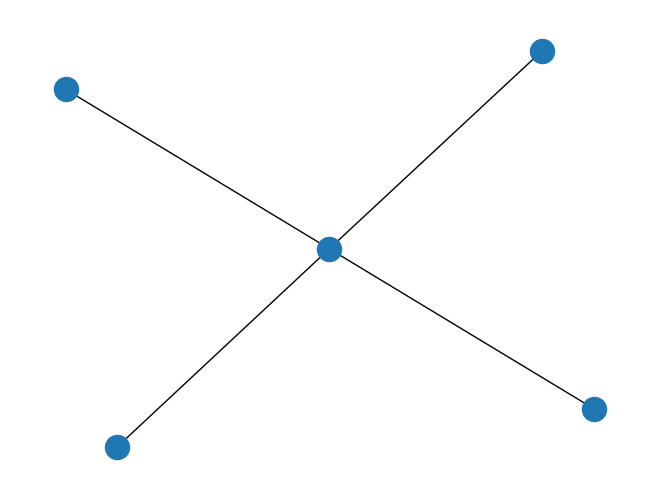

In [7]:
import networkx as nx
import torch_geometric

g = torch_geometric.utils.to_networkx(x, to_undirected=True)
nx.draw(g)

Model with global readout.

In [5]:
lr = 0.01

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import global_mean_pool, GCNConv


# Create a DataLoader for the filtered dataset
batch_size = 1
dataloader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

# Define a simple Graph Neural Network (GNN) model
class GNNModel(nn.Module):
    def __init__(self, num_features, hidden_dim):
        super(GNNModel, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = global_mean_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize and train the GNN model
model = GNNModel(filtered_dataset[0].num_features, hidden_dim=10)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()


In [45]:
n_params = sum([p.numel() for p in model.parameters()])
print("number of parameters is ", n_params)

number of parameters is  181


In [41]:
run = wandb.init(
    # Set the project where this run will be logged
    project=wandb_prj_name,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "n_params": n_params,
        "model": "classical",
        "num_nodes": max_nodes,
        "batch_size": batch_size,
    })

In [46]:

# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for data in dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y[:, 0:1].float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
    wandb.log({"epoch": epoch+1, "loss": avg_loss})

# Save the trained model
# torch.save(model.state_dict(), 'gnn_model.pth')
wandb.finish()

Epoch 1/400, Loss: 0.3457
Epoch 2/400, Loss: 0.3328
Epoch 3/400, Loss: 0.3344
Epoch 4/400, Loss: 0.3286
Epoch 5/400, Loss: 0.3328
Epoch 6/400, Loss: 0.3263
Epoch 7/400, Loss: 0.3118
Epoch 8/400, Loss: 0.3002
Epoch 9/400, Loss: 0.2819
Epoch 10/400, Loss: 0.2691
Epoch 11/400, Loss: 0.2491
Epoch 12/400, Loss: 0.2418
Epoch 13/400, Loss: 0.2399
Epoch 14/400, Loss: 0.2333
Epoch 15/400, Loss: 0.2228
Epoch 16/400, Loss: 0.2275
Epoch 17/400, Loss: 0.2315
Epoch 18/400, Loss: 0.2178
Epoch 19/400, Loss: 0.2294
Epoch 20/400, Loss: 0.2164
Epoch 21/400, Loss: 0.1985
Epoch 22/400, Loss: 0.1928
Epoch 23/400, Loss: 0.1916
Epoch 24/400, Loss: 0.1854
Epoch 25/400, Loss: 0.1820
Epoch 26/400, Loss: 0.1893
Epoch 27/400, Loss: 0.2113
Epoch 28/400, Loss: 0.2023
Epoch 29/400, Loss: 0.1765
Epoch 30/400, Loss: 0.1897
Epoch 31/400, Loss: 0.2057
Epoch 32/400, Loss: 0.1782
Epoch 33/400, Loss: 0.1715
Epoch 34/400, Loss: 0.1645
Epoch 35/400, Loss: 0.1693
Epoch 36/400, Loss: 0.1799
Epoch 37/400, Loss: 0.1676
Epoch 38/4

In [ ]:
# wandb.finish()

In [4]:
len(filtered_dataset)

108

In [31]:
x = dataset[0]

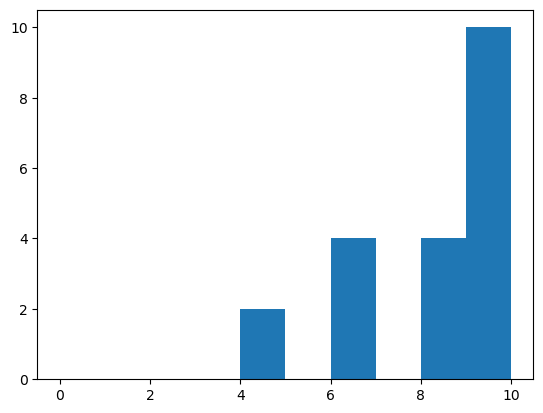

In [32]:
import matplotlib.pyplot as plt

nodes = [x.num_edges for x in dataset]

plt.hist(nodes, bins=10, range=(0, 10));

## Quantum Network

In [39]:
#params
# max_nodes = 

In [8]:
import pennylane as qml
import pennylane.numpy as np

In [13]:
# final stage
from typing import Literal
import torch
import torch.nn as nn
import torch.nn.functional as F

def encoding_layer(values):
    """
    pooling layer, that encodes params, or edge features in nodes

    values: [num nodes] tensor
    """
    for w in range(values.shape[0]):
        qml.RX(values[w], w)

def edged_entengling_layer(edge_index, rot_param):
    for i in range(edge_index.shape[1]):
        qml.IsingYY(rot_param, wires=[edge_index[0,i], edge_index[1,i]])

def measurement(n_qubits):
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def parametrised_rotations(angles, wires):
    for w in wires:
        qml.Rot(*angles, w)
    

n_layers = 3
def circuit(inputs, params, edge_weights, atoms_weight: list[5]):
    data = inputs
    num_atoms = data.x.shape[0]
    atom_embeddings = data.x @ atoms_weight   # [num_atoms, 5] * [5] -> [num_atoms]
    # assert atom_embeddings.shape == (1,)
    edge_index = data.edge_index
    for l in range(n_layers):
        encoding_layer(atom_embeddings)
        parametrised_rotations(params[2*l], wires=range(num_atoms))
        edged_entengling_layer(edge_index, edge_weights[l])
        parametrised_rotations(params[2*l+1], wires=range(num_atoms))
    return measurement(num_atoms)

class QuantumGNN(nn.Module):
    def init_weight(self, weights_shape):
        weights = {}
        for name, shape in weights_shape.items():
            t = torch.nn.Parameter(torch.rand(*shape, requires_grad=True).float()*2*np.pi, requires_grad=True)
            self.register_parameter(name, t)
            weights[name] = t
        return weights
    def __init__(self, readout: Literal["global", "local"], max_qubits: int):
        super().__init__()
        device = qml.device("lightning.qubit", wires=max_qubits)
        self.qnode = qml.QNode(circuit, device)
        weights_shape = {"params": [2*n_layers, 3], "edge_weights":[n_layers], "atoms_weight": [5]}

        self.qnode_weights = self.init_weight(weights_shape)
        
        self.qlayer = qml.qnn.TorchLayer(self.qnode, weights_shape)

        self.fc1 = nn.Linear(1, 2)
        self.fc2 = nn.Linear(2, 1)
    def forward(self, batch):
        # print(batch)
        results = []
        for i in range(len(batch)):
            g = batch[i]
            # print(g)
            exps = self.qnode(g, **self.qnode_weights)
            exps = torch.stack(exps).float()
            # print(exps)
            # assert exps.shape == (g.num_atoms
            avgs = torch.mean(exps, axis=0, keepdim=True)
            results.append(avgs)
        x = torch.stack(results)    
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
model = QuantumGNN('global', max_nodes)
n_params = sum([p.numel() for p in model.parameters()])
print("number of parameters is ", n_params)

number of parameters is  59


In [15]:
lr = 0.01
batch_size = 64

run = wandb.init(
    # Set the project where this run will be logged
    project=wandb_prj_name,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "n_params": n_params-26, # todo fix this. Remove doublecheck of the params
        "model": "quantum",
        "num_nodes": max_nodes,
        "batch_size": batch_size,
    })

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss,█▂▁▃▄▃▂▁▁▁▂▂▂▂▁▁
epoch,157
loss,0.33233


In [16]:
from tqdm.auto import tqdm 
import os
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Create a DataLoader for the filtered dataset
dataloader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

chkp_folder = "checkpoints3"
os.makedirs(chkp_folder, exist_ok=True)

# Training loop
num_epochs = 300
for epoch in tqdm(range(0, num_epochs)):
    model.train()
    total_loss = 0
    for data in dataloader:
        # print([t[0] for t in model.parameters()])
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y[:, 0:1].float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
    wandb.log({"epoch": epoch+1, "loss": avg_loss})
    torch.save(model.state_dict(), os.path.join(chkp_folder, f'qgnn_model_{epoch}.pth'))

# Save the trained model
wandb.finish()

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1/300, Loss: 0.7359
Epoch 2/300, Loss: 0.7108
Epoch 3/300, Loss: 0.6867
Epoch 4/300, Loss: 0.6644
Epoch 5/300, Loss: 0.6431
Epoch 6/300, Loss: 0.6229
Epoch 7/300, Loss: 0.6041
Epoch 8/300, Loss: 0.5866
Epoch 9/300, Loss: 0.5707
Epoch 10/300, Loss: 0.5573
Epoch 11/300, Loss: 0.5456


In [ ]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,36
loss,2.83641


In [53]:
p = next(iter(model.parameters()))
p[:]

Parameter containing:
tensor([[3.1551, 4.4484, 5.0641],
        [5.5594, 0.6541, 1.0174],
        [5.0052, 0.1665, 0.7415],
        [2.9890, 2.2093, 2.4488],
        [4.4664, 5.4787, 2.9617],
        [0.0323, 0.4213, 5.6541]], requires_grad=True)

In [62]:
p.grad_fn

In [ ]:
data[0]

Data(x=[4, 5], edge_index=[2, 6], edge_attr=[6, 4], y=[1, 19], pos=[4, 3], idx=[1], name='gdb_25', z=[4])

(array([7., 4., 3., 7., 4., 4., 5., 4., 3., 2.]),
 array([-1.        , -0.80000001, -0.60000002, -0.40000001, -0.2       ,
         0.        ,  0.2       ,  0.40000001,  0.60000002,  0.80000001,
         1.        ]),
 <BarContainer object of 10 artists>)

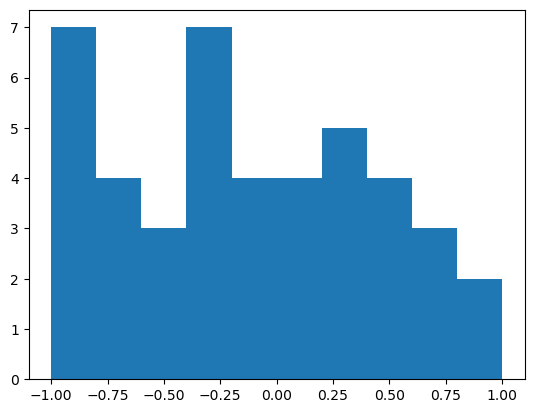

In [91]:
import matplotlib.pyplot as plt


prop = [data.y[0, 0] for data in filtered_dataset]
plt.hist(prop)

Model loading

In [10]:
model.load_state_dict(torch.load("./checkpoints2/qgnn_model_140.pth"))

<All keys matched successfully>

## Predictions visualization

In [11]:
import matplotlib.pyplot as plt


def visualize_predictions(model, dataloader, feature_idx):
    predictions = []
    answers = []
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            output = model(data)
            predictions.append(output)
            answers.append(data.y[:, feature_idx:feature_idx+1])
    predictions = torch.cat(predictions)
    answers = torch.cat(answers)
    plt.plot(answers, predictions, "o")
    plt.xlabel("correct answer")
    plt.ylabel("prediction")
    mse = criterion(answers, predictions)
    print(mse)
    return predictions, answers

In [12]:
batch_size = 1
dataloader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

Text(0.5, 1.0, 'Q model, 26 params')

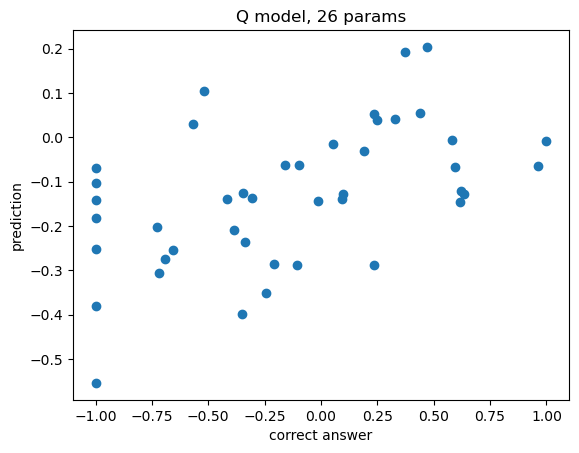

In [20]:
predictions, answers  = visualize_predictions(model, dataloader, 0)
plt.title("Q model, 26 params")

Text(0.5, 1.0, 'C model, 34 params')

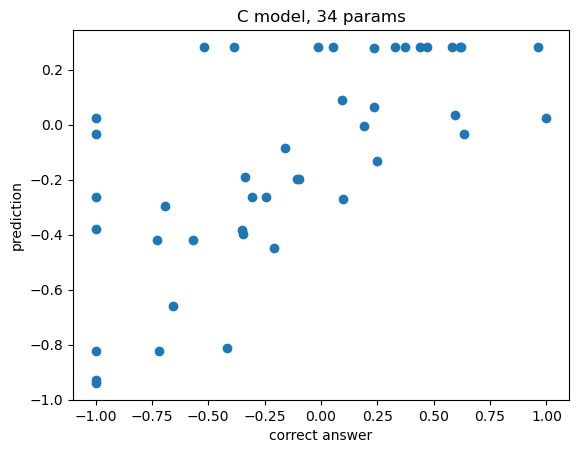

In [43]:
predictions, answers  = visualize_predictions(model, dataloader, 0)
plt.title("C model, 34 params")

Text(0.5, 1.0, 'C model, 181 params')

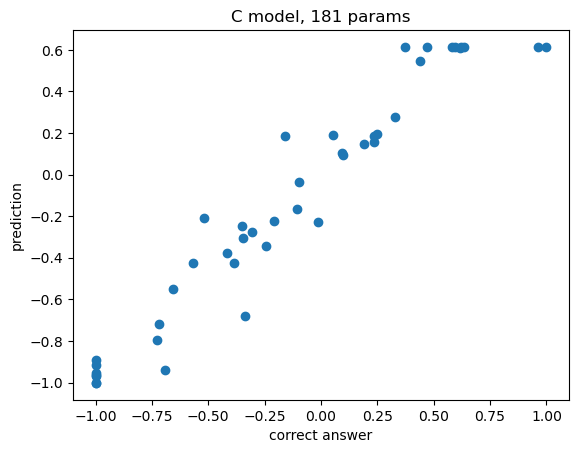

In [47]:
predictions, answers  = visualize_predictions(model, dataloader, 0)
plt.title("C model, 181 params")

NameError: name 'criterion' is not defined

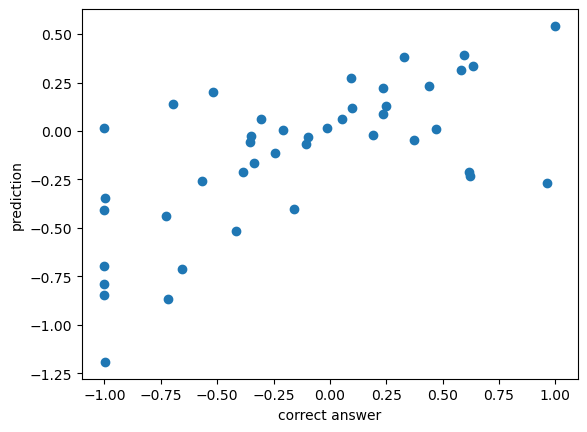

In [1]:
predictions, answers  = visualize_predictions(model, dataloader, 0)
plt.title("Q model, 33 params")